In [60]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [61]:
def calc_sta(stimulus, spike_train, start = 0, end = 1):
    """
    Calculates the spike-triggered average (STA) of a 2D stimulus of shape [time, x, y]
    
    Args:
        stimulus (np.ndarray): 3D array of shape [time, height, width], where each 2D frame is the stimulus at a given time.
        spike_train (np.ndarray): 1D array of shape with the same length as stimulus in time, consisting of 0s and 1s (0: no spike, 1: spike)
        start (int): Start offset relative to each spike time.
        end (int): End offset relative to each spike time.

    Returns:
        sta: The average stimulus that caused a spike with respect to the given window (start/end).
    
    Note:
        By default start and end are set to take only the stimulus that was present during each spike.
    """

    spikes, = np.where(spike_train == 1)
    if spikes.size == 0:
        raise ValueError('Found no spikes in the given spike train.')
    
    sta = np.zeros((stimulus.shape[1],stimulus.shape[2]))
    pattern_count = 0

    for spike in spikes:
        window_start = spike + start
        window_end = spike + end
        if window_start < 0 or window_end > len(stimulus):
            print(f'Exceeding: {window_start} - {window_end}')
            continue

        for i in range(window_start, window_end):
            sta += stimulus[i]
            pattern_count += 1

    if pattern_count == 0:
        raise ValueError('No patterns found. The heck?')

    sta /= pattern_count
    sta -= sta.mean()
    
    return sta

In [ ]:
data_dir = ''
gauss_spike_train = np.load(os.path.join(data_dir, 'spike_train_gauss_1.npy'))
gauss_stimulus = np.load(os.path.join(data_dir, 'stimulus_gauss_1.npy'))
gauss_filter = np.load(os.path.join(data_dir, f'filter_gauss_1.npy'))

gabor_spike_train = np.load(os.path.join(data_dir, 'spike_train_gabor_1.npy'))
gabor_stimulus = np.load(os.path.join(data_dir, 'stimulus_gabor_1.npy'))
gabor_filter = np.load(os.path.join(data_dir, f'filter_gabor_1.npy'))

ricker_spike_train = np.load(os.path.join(data_dir, 'spike_train_ricker_1.npy'))
ricker_stimulus = np.load(os.path.join(data_dir, 'stimulus_ricker_1.npy'))
ricker_filter = np.load(os.path.join(data_dir, f'filter_ricker_1.npy'))



In [ ]:
start = 0
end = 1

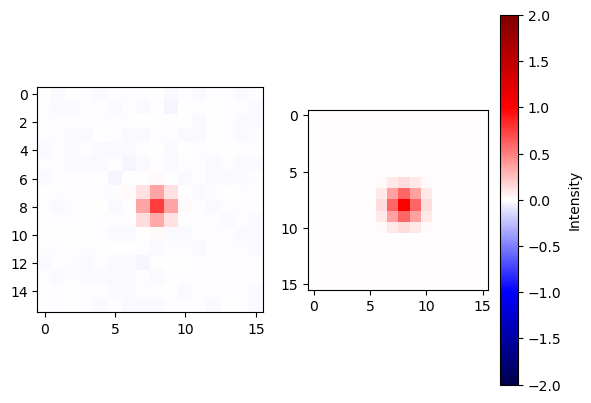

In [ ]:
gauss_sta = calc_sta(gauss_stimulus, gauss_spike_train, start, end)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(gauss_sta, vmin = -2, vmax = 2, cmap = "seismic")
a = axs[1].imshow(gauss_filter, vmin = -2, vmax = 2, cmap = "seismic")

plt.colorbar(a, label="Intensity")
plt.title(f'')
plt.show()

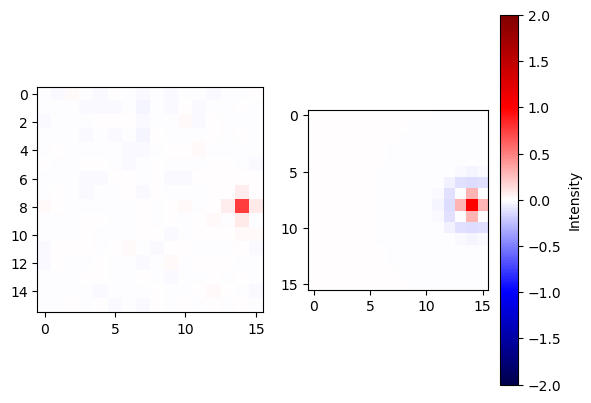

In [ ]:
ricker_sta = calc_sta(ricker_stimulus, ricker_spike_train, start, end)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(ricker_sta, vmin = -2, vmax = 2, cmap = "seismic")
a = axs[1].imshow(ricker_filter, vmin = -2, vmax = 2, cmap = "seismic")

plt.colorbar(a, label="Intensity")
plt.title(f'')
plt.show()

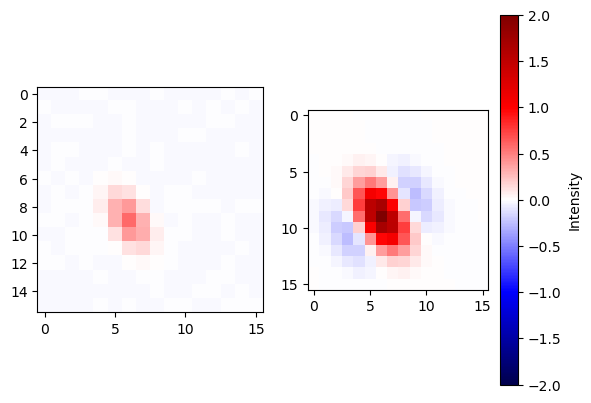

In [ ]:
gabor_sta = calc_sta(gabor_stimulus, gabor_spike_train, start, end)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(gabor_sta, vmin = -2, vmax = 2, cmap = "seismic")
a = axs[1].imshow(gabor_filter, vmin = -2, vmax = 2, cmap = "seismic")

plt.colorbar(a, label="Intensity")
plt.title(f'')
plt.show()

In [ ]:
mse = np.mean((gauss_sta - gauss_filter)**2)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 0.0030


In [ ]:
from skimage.metrics import structural_similarity as ssim

def compute_ssim(p1, p2):
    return ssim(p1, p2, data_range=p2.max() - p2.min())

In [ ]:
compute_ssim(gauss_sta, gauss_filter)

0.30924807042289115